In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np

In [2]:
f = pd.read_csv('final raw data.csv', na_filter=False)

In [8]:
data = f.drop(['Full count Pupae', 'Household_ID', 'Larvae'], axis=1)

In [9]:
data.rename(columns={'Full count Larvae': 'class'}, inplace=True)
data.head(5)

,Hamlet,Container_ID,Container_position,Water_level,Lid,Fish,Meso,Micronecta,Source,Treatment,class
0,0,1,0,25,1,0,0,0,0,0,206.7
1,0,2,1,25,1,0,0,0,1,0,0.0
2,0,5,0,25,0,0,0,0,1,0,0.0
3,0,6,0,25,1,0,0,0,0,1,0.0
4,0,5,1,30,1,0,0,0,0,1,0.0


In [11]:
pos_data = data[data['class'] >= 1]
neg_data = data[data['class'] == 0]

print (pos_data.shape)
print (neg_data.shape)

(50, 11)
(500, 11)


In [12]:
pos_len = len(pos_data.index)
random_pos_data = pos_data.take(np.random.permutation(len(pos_data))[:pos_len])

samples = int(0.75 * pos_len)
train_pos_data = random_pos_data[:samples]
test_pos_data = random_pos_data[samples:]

In [13]:
final_pos_data = pd.concat([train_pos_data]*5)
times = len(final_pos_data)
final_neg_data = neg_data.take(np.random.permutation(len(neg_data))[:times])
frames = [final_pos_data, final_neg_data]
final_data = pd.concat(frames)
print (final_data.shape)

(370, 11)


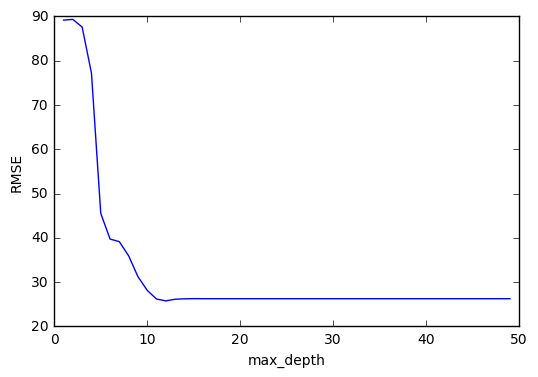

In [46]:
features = ['Hamlet', 'Container_ID', 'Water_level', 'Container_position', 'Meso', 'Treatment']
Y = final_data['class']
X = final_data[features]

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt
treereg = DecisionTreeRegressor(random_state=1)
treereg

max_depth_range = range(1, 50)
RMSE_scores = []
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, Y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

In [47]:
treereg = DecisionTreeRegressor(max_depth=10, random_state=1)
treereg.fit(X, Y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [49]:
pd.DataFrame({'feature':features, 'importance':treereg.feature_importances_})

,feature,importance
0,Hamlet,0.211544
1,Container_ID,0.153829
2,Water_level,0.383817
3,Container_position,0.004409
4,Meso,0.211271
5,Treatment,0.035131


In [52]:
from sklearn import metrics
test_pos_data_X = test_pos_data[features]
test_pos_data_y = test_pos_data['class']
y_pred = treereg.predict(test_pos_data_X)

np.sqrt(metrics.mean_squared_error(test_pos_data_y, y_pred))


51.493449919532331

In [53]:
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)

from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X_scaled)

print (X_pca.shape)

(370, 2)


In [54]:
from sklearn.svm import SVR
from sklearn.metrics import precision_score

pca = PCA(n_components=0.8,whiten=True)
train_x = pca.fit_transform(X)
test_x = pca.transform(test_pos_data_X)
train_y = Y

clf = SVR(C=1.0, epsilon=0.2)
clf.fit(train_x, Y) 



y_pred = clf.predict(test_x)
np.sqrt(metrics.mean_squared_error(test_pos_data_y, y_pred))


51.224319615858214